# AAI3001 Final Project - Preliminary Research Notebook
### Group 8
- Chua Chen Yi
- Wong Jun Kai
- Leena Soo Wei Qi
- Heng Yu Xin

#### In this notebook, we conduct a brief sanity check of our progress, primarily to confirm that:
1. Our dataset has been properly formatted.
2. We are able to apply transfer learning to a pre-trained YOLO model.
3. The initial model performance is satisfactory.

## Dataset Notes
Our initial dataset consists of 353 Images. These are recorded from the 3D printer's built in webcam. We obtain our images as snapshots from a mix of timelapse and regular videos.
- #### Timelapse Videos
These captures movement across the entire print cycle, and are representative of an entire print, which takes more than an hour on averages. Frames are captured at the start of each layer, where each layer is 0.2mm in height. Therefore an object of 1cm will have 5 frames captures. However, a shortfall of this method is key moments, such as the start of a print failure occuring might get missed if they do not occur at the start of the new layer.
- #### Regular Videos
These captures movement across a specific moment in the print cycle. We record the entire footage and pick out key moments. We use this to capture the initial moments where the print failure occurs. As this is a regular 30FPS video, we are able to capture more frames and populate our dataset with these key moments. As 30FPS will generate too many similar images, we record them in a 15:1 ratio (We capture one frame for every 15 frame of video). This is till much faster than timelapse, which might only capture a single image every 2+ mins.

## Dataset Annotation
We use [makesense](https://makesense.ai) to annotate our dataset, which also conveniently formats in YOLO. As we are only interesting in single class; failure, we only use a single label.

# Preview dataset images

In [1]:
# Dataset root folder
dataset_path = r"C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint"

# Images
train_folder = dataset_path + r"\images\train"
test_folder = dataset_path + r"\images\test"
val_folder = dataset_path + r"\images\val"

# Labels
train_label_folder = dataset_path + r"\labels\train"
test_label_folder = dataset_path + r"\labels\test"
val_label_folder = dataset_path + r"\labels\val"

In [2]:
# Import Stuff
import os
import random
import cv2
from matplotlib import pyplot as plt

**NOTE! If random.sample returns a background image, no boxes will be drawn!**

In [7]:
# Helper function to preview bounding box. 
def draw_bounding_boxes(image, label_file):
    h, w, _ = image.shape  # Get the image dimensions

    # Read the label file
    with open(label_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Parse the YOLO label format
        parts = line.strip().split()
        class_id, center_x, center_y, bbox_width, bbox_height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x1 = int((center_x - bbox_width / 2) * w)
        y1 = int((center_y - bbox_height / 2) * h)
        x2 = int((center_x + bbox_width / 2) * w)
        y2 = int((center_y + bbox_height / 2) * h)

        # Draw the bounding box (red color, thicker border)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), thickness=6)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image

C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint\labels\train\BG130.txt
C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint\labels\train\BG109.txt
C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint\labels\train\FA11.txt


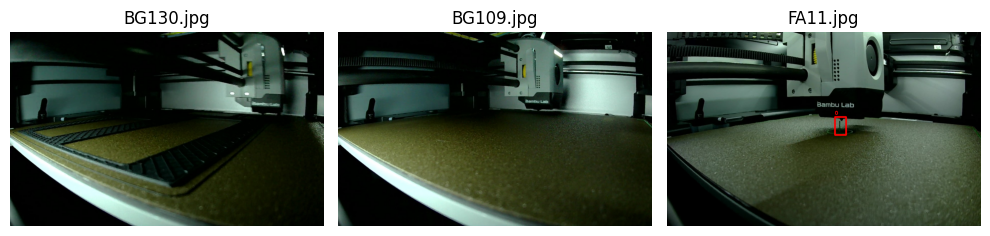

In [8]:
# Get a list of all image files in the folder
image_files = [f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if there are enough images in the folder
if len(image_files) < 3:
    print(f"Err: Check folder paths")
    
else:
    # Select 3 random images
    selected_images = random.sample(image_files, 3)

    # Display the selected images with bounding boxes
    plt.figure(figsize=(10, 5))

    for i, img_file in enumerate(selected_images):
        # Read the image using OpenCV
        img_path = os.path.join(train_folder, img_file)
        img = cv2.imread(img_path)

        # Find the corresponding label file
        label_file = os.path.join(train_label_folder, os.path.splitext(img_file)[0] + '.txt')
        print(label_file)

        # If a label file exists, draw the bounding boxes
        if os.path.exists(label_file):
            img = draw_bounding_boxes(img, label_file)

        # Convert BGR to RGB for displaying with Matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(img_file)
        plt.axis('off')

    # Show the images
    plt.tight_layout()
    plt.show()

# Sanity Check - Train Model
#### Use transfer learning on a pre-trained YOLOv11 model, then evaluate

In [9]:
# Import stuff
from ultralytics import YOLO

In [10]:
# Create a new YOLO model from scratch
model = YOLO("yolo11n.yaml")

# Load a pretrained YOLO model
model = YOLO("yolo11n.pt")

In [11]:
# Train the model using the 'coco8.yaml' dataset for 3 epochs
results = model.train(data="datasets/3dprint.yaml", epochs=20)

Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=datasets/3dprint.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint\labels\train.cache... 86 images
val: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint\labels\val.cache... 30 images, 55


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.34G      2.675      8.041      1.864         13        640: 100%|██████████| 14/14 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41   0.000902      0.561    0.00246   0.000761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.36G      2.489      5.287      1.654         20        640: 100%|██████████| 14/14 [00:01<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41    0.00098       0.61    0.00152   0.000509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.36G      2.228       5.05      1.718          8        640: 100%|██████████| 14/14 [00:01<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41   0.000863      0.537    0.00117   0.000405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.36G      2.414      4.128      1.698         14        640: 100%|██████████| 14/14 [00:01<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41    0.00114      0.707     0.0018   0.000665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.36G      2.416      3.972        1.8         24        640: 100%|██████████| 14/14 [00:01<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41    0.00141      0.878    0.00497    0.00206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.36G      2.274      3.674      1.809         24        640: 100%|██████████| 14/14 [00:01<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.714      0.122      0.377      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.36G      2.121      3.048      1.645         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.295      0.293      0.198     0.0621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.36G      2.206      3.016      1.612         10        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41       0.55      0.359       0.43      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.36G      2.103      2.983      1.607          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.617      0.512      0.597      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.36G      2.131      2.529      1.638         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.632      0.634      0.671      0.226


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.36G       2.15      3.723      1.773          9        640: 100%|██████████| 14/14 [00:01<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.389      0.122      0.173     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.36G      2.174      3.661      1.733          7        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.538      0.512      0.575      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.36G      2.115      3.469      1.656          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.715      0.463      0.628      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.36G      2.014      3.159      1.612          6        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.587      0.683      0.612      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.36G      2.054      2.989      1.656          9        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.619      0.633      0.655      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.36G      2.084      3.193      1.677          4        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.785      0.537      0.694      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.36G      1.888      2.972      1.563         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.596      0.634      0.698      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.36G      1.933      3.195      1.585          5        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.808      0.634      0.744      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.36G      1.868      2.733      1.579         15        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.792      0.585      0.685      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.36G       1.98      2.961      1.633          6        640: 100%|██████████| 14/14 [00:01<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         85         41      0.779      0.601      0.711      0.254



20 epochs completed in 0.021 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.4MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0


                   all         85         41      0.811      0.634      0.745      0.262
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\train


In [12]:
# Evaluate the model's performance on the validation set
results = model.val()

Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint\labels\val.cache... 30 images, 55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<0


                   all         85         41      0.828      0.634      0.742      0.256
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train2
